# Classification - Is the flight delayed or not ?

This notebook will focus on classification of flights based on flights information, before going through regression analysis.

Through this notebook we are going to try different techniques to build and improve our model's performance:
 - Use cross-validation techniques
 - Feature engineering
 - Handle the class imbalance of the target variable
 - Try different modelling techniques - Stacking classifier, Voting classifiers, ensembling...
 - Data transformations
 - Feature Selection techniques such as RFE, Tree-based feature importance...

Table of contents:

1. [Import relevant libraries](#Libraries)
2. [Load files](#Load)
3. [Preview files](#Preview)
5. [Data exploration and transformation](#Exploration)
6. [Target distribution](#Target)
7. [Outliers](#Outliers)
8. [Correlations](#Correlations)
9. [Model training](#Model)
10. [Test set predictions](#Predictions)
11. [Creating a submission file](#Submission)
12. [Tips to improve model performance](#Tips)

<a name = "Libraries"></a>
## 1. Import relevant libraries

In [44]:
# Pre-requisites
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Store the classifier models to save time
import joblib

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Classifiers from scikit-learn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Performance metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Imbalanced dataset helpers
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a name = "Load"></a>
## 2. Load files

In [4]:
# Path to your file within Google Drive
file_path = '/content/drive/MyDrive/PFE/flights.csv'

# Read the file using pandas
df = pd.read_csv(file_path)

<a name = "Preview"></a>
## 3. Preview files

In [5]:
df.head()

,aircraft,date,from,to,flight,flight_time,scheduled_time_departure,actual_time_departure,scheduled_time_arrival,status,actual_time_arrival,from_city,to_city,rounded_hour,airport,delay_time
0,se-rrb,2024-03-20,arn,szg,D84471,2024-03-20T01:50:00.000+01:00,2024-03-20T10:15:00.000+01:00,2024-03-20T10:28:00.000+01:00,2024-03-20T12:25:00.000+01:00,On Time,2024-03-20T12:18:00.000+01:00,stockholm,salzburg,2024-03-20T12:00:00.000+01:00,szg,-7.0
1,se-rrb,2024-03-03,ume,arn,D84014,2024-03-03T00:50:00.000+01:00,2024-03-03T17:45:00.000+01:00,2024-03-03T17:54:00.000+01:00,2024-03-03T18:50:00.000+01:00,On Time,2024-03-03T18:44:00.000+01:00,umea,stockholm,2024-03-03T19:00:00.000+01:00,arn,-6.0
2,se-rrb,2023-12-03,arn,lla,D84039,2023-12-03T01:07:00.000+01:00,2023-12-03T13:05:00.000+01:00,2023-12-03T13:18:00.000+01:00,2023-12-03T14:25:00.000+01:00,On Time,2023-12-03T14:24:00.000+01:00,stockholm,lulea,2023-12-03T14:00:00.000+01:00,lla,-1.0
3,se-rrb,2023-12-03,lla,arn,D84036,2023-12-03T01:04:00.000+01:00,2023-12-03T10:15:00.000+01:00,2023-12-03T10:31:00.000+01:00,2023-12-03T11:35:00.000+01:00,On Time,2023-12-03T11:35:00.000+01:00,lulea,stockholm,2023-12-03T12:00:00.000+01:00,arn,0.0
4,se-rrb,2023-08-11,pmi,arn,D84214,2023-08-11T03:13:00.000+01:00,2023-08-11T20:05:00.000+01:00,2023-08-11T20:05:00.000+01:00,2023-08-11T23:45:00.000+01:00,On Time,2023-08-11T23:18:00.000+01:00,palma de mallorca,stockholm,2023-08-11T00:00:00.000+01:00,arn,-27.0


<a name = "Exploration"></a>
## 5. Data exploration and transformation

Axes(0.125,0.11;0.698618x0.77)


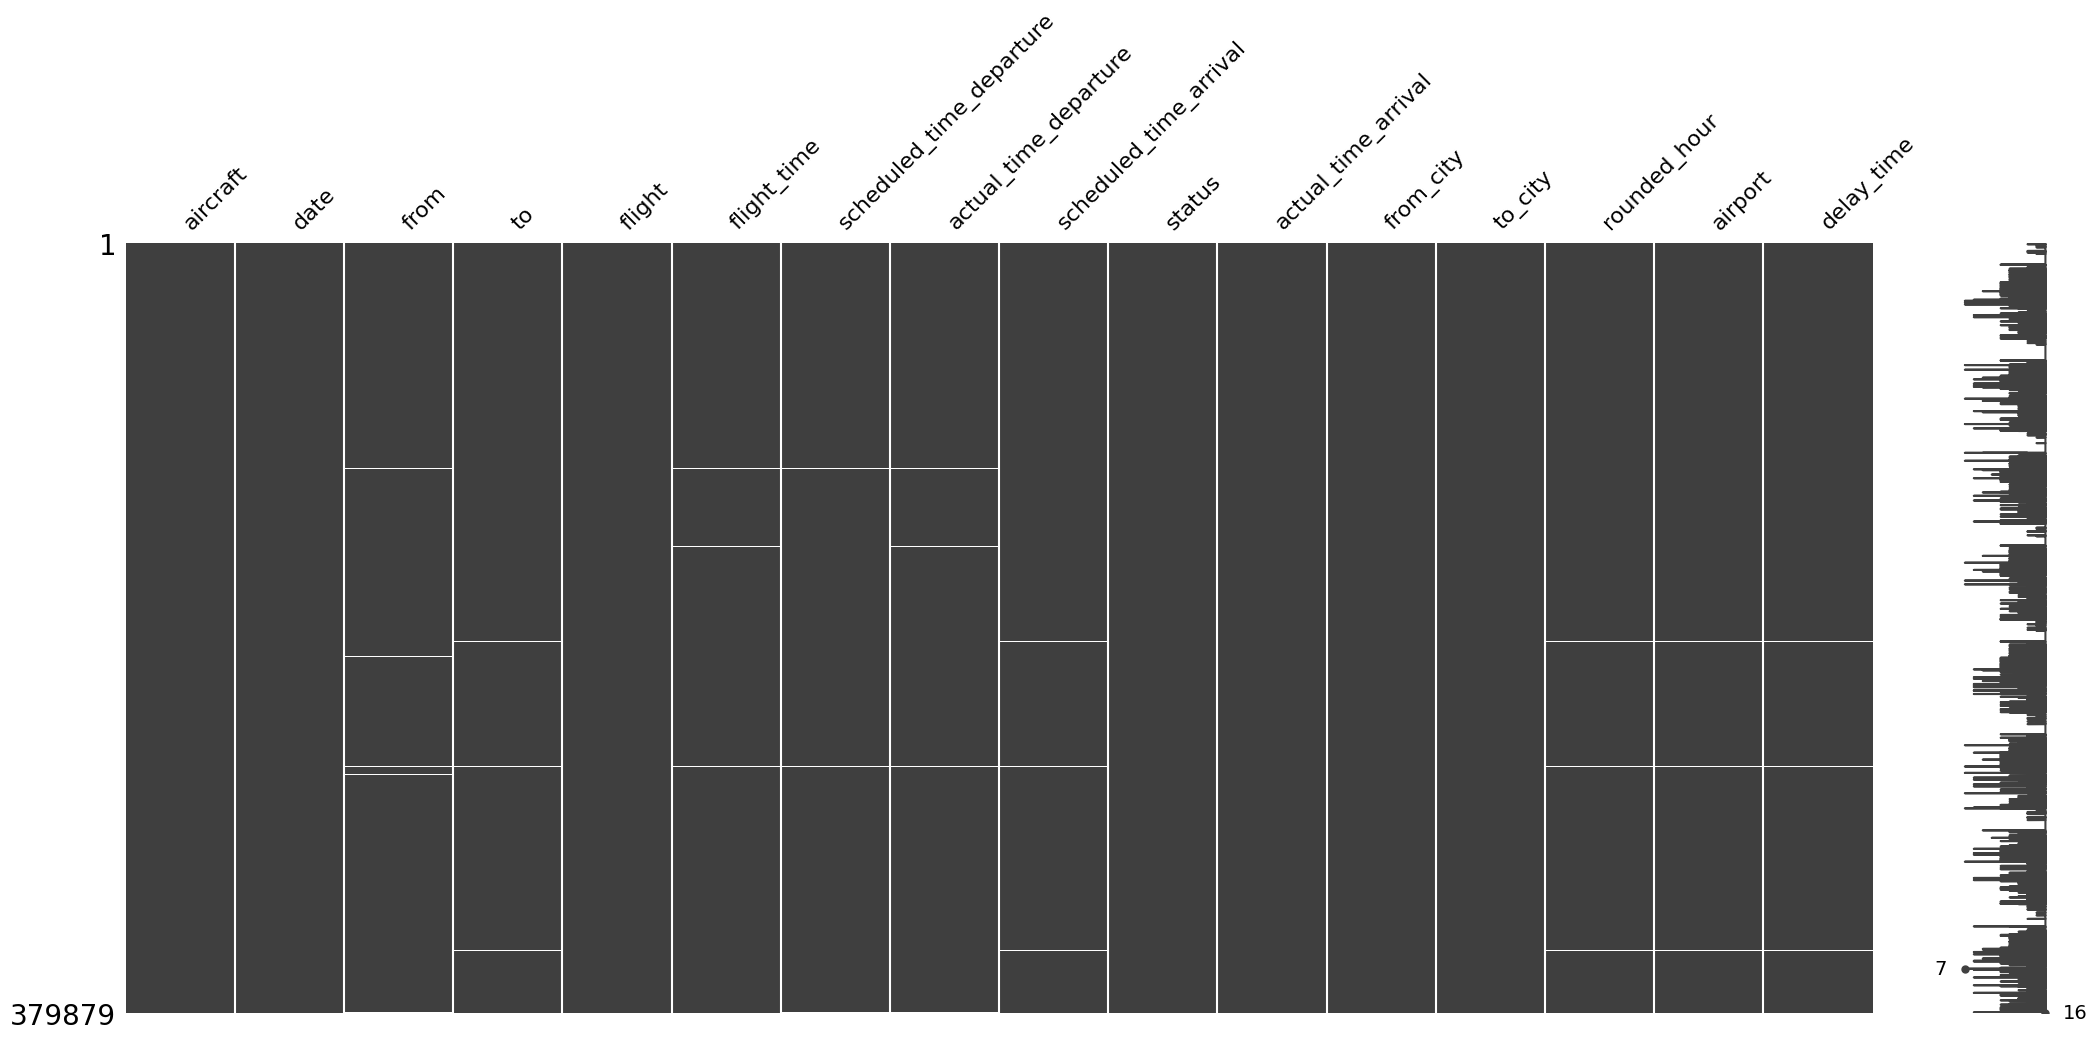

In [ ]:
print(msno.matrix(df))

In [7]:
df.dropna(inplace=True)

In [14]:
# Check for any missing values
df.isnull().sum().any()

False

In [55]:
# Check for duplicates
df.duplicated().sum()

93

In [8]:
df['status'] = df['status'].map({"On Time": 0, "Delayed": 1})

# Convert datetime string column to datetime type
df['flight_time'] = pd.to_datetime(df['flight_time']).dt.tz_localize(None)
df['scheduled_time_departure'] = pd.to_datetime(df['scheduled_time_departure']).dt.tz_localize(None)
df['actual_time_departure'] = pd.to_datetime(df['actual_time_departure']).dt.tz_localize(None)
df['scheduled_time_arrival'] = pd.to_datetime(df['scheduled_time_arrival']).dt.tz_localize(None)
df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
df["status"] = df["status"].astype('int')

df["departure_delay"] = df["actual_time_departure"] - df["scheduled_time_departure"]

# Convert the departure delay to minutes
df['departure_delay'] = df['departure_delay'].dt.total_seconds() / 60

df["departure_delay_15"] = df["departure_delay"] > 15
df["departure_delay_15"] = df["departure_delay_15"].astype('int')

df['year'] = df['scheduled_time_arrival'].dt.year
df['month'] = df['scheduled_time_arrival'].dt.month
df['day'] = df['scheduled_time_arrival'].dt.day
df['hour'] = df['scheduled_time_arrival'].dt.hour
df['dayofweek'] = df['scheduled_time_arrival'].dt.dayofweek
df['quarter'] = df['scheduled_time_arrival'].dt.quarter
df['is_year_start'] = df['scheduled_time_arrival'].dt.is_year_start
df['is_year_end'] = df['scheduled_time_arrival'].dt.is_year_end

df["is_year_start"] = df["is_year_start"].astype('int')
df["is_year_end"] = df["is_year_end"].astype('int')

cols = ['flight', 'aircraft', 'from', 'to', 'from_city',
       'to_city', 'year', 'month', 'day', 'hour', 'dayofweek', 'quarter', 'is_year_start', 'is_year_end', 'departure_delay', 'departure_delay_15', 'status']

df = df[cols]

In [11]:
# encode categorical data into numeric values
labelEncoder = LabelEncoder()
df["flight"] = labelEncoder.fit_transform(df["flight"])
df["aircraft"] = labelEncoder.fit_transform(df["aircraft"])
df["from"] = labelEncoder.fit_transform(df["from"])
df["to"] = labelEncoder.fit_transform(df["to"])
df["from_city"] = labelEncoder.fit_transform(df["from_city"])
df["to_city"] = labelEncoder.fit_transform(df["to_city"])

In [52]:
df.head()

,flight,aircraft,from,to,from_city,to_city,year,month,day,hour,dayofweek,quarter,is_year_start,is_year_end,departure_delay,departure_delay_15,status
0,25459,412,98,1800,1699,1554,2024,3,20,12,2,1,0,0,13.0,0,0
1,25337,412,1947,96,1859,1699,2024,3,3,18,6,1,0,0,9.0,0,0
2,25349,412,98,1106,1699,1033,2023,12,3,14,6,4,0,0,13.0,0,0
3,25347,412,1107,96,1034,1699,2023,12,3,11,6,4,0,0,16.0,1,0
4,25390,412,1494,96,1334,1699,2023,8,11,23,4,3,0,0,0.0,0,0


In [12]:
# Check statistical summaries of the dataset
df.describe()

,flight,aircraft,from,to,from_city,to_city,year,month,day,hour,dayofweek,quarter,is_year_start,is_year_end,departure_delay,departure_delay_15,status
count,540197.000000,540197.000000,540197.000000,540197.000000,540197.000000,540197.000000,540197.000000,540197.000000,540197.000000,540197.000000,540197.000000,540197.000000,540197.000000,540197.000000,540197.000000,540197.000000,540197.000000
mean,41148.584150,240.105282,1004.544786,1003.279581,974.686189,974.006957,2023.270718,6.514161,15.784875,14.033234,3.008767,2.504233,0.002536,0.002499,12.432940,0.512791,0.188474
std,23665.553001,138.082881,610.597940,612.740632,568.592111,570.754773,0.444331,3.412502,8.805278,5.627771,1.996790,1.109571,0.050296,0.049928,155.094672,0.499837,0.391090
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2023.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-1439.000000,0.000000,0.000000
25%,20720.000000,123.000000,460.000000,457.000000,456.000000,452.000000,2023.000000,4.000000,8.000000,10.000000,1.000000,2.000000,0.000000,0.000000,7.000000,0.000000,0.000000
50%,43037.000000,237.000000,997.000000,994.000000,1011.000000,1010.000000,2023.000000,7.000000,16.000000,14.000000,3.000000,3.000000,0.000000,0.000000,16.000000,1.000000,0.000000
75%,60775.000000,364.000000,1519.000000,1523.000000,1468.000000,1471.000000,2024.000000,9.000000,23.000000,19.000000,5.000000,3.000000,0.000000,0.000000,31.000000,1.000000,0.000000
max,84286.000000,471.000000,2165.000000,2166.000000,2016.000000,2017.000000,2024.000000,12.000000,31.000000,23.000000,6.000000,4.000000,1.000000,1.000000,1438.000000,1.000000,1.000000


In [ ]:
df.dtypes

flight                  int64
aircraft                int64
from                    int64
to                      int64
from_city               int64
to_city                 int64
year                    int32
month                   int32
day                     int32
hour                    int32
dayofweek               int32
quarter                 int32
is_year_start           int64
is_year_end             int64
departure_delay       float64
departure_delay_15      int64
status                  int64
dtype: object

<a name = "Target"></a>
## 6. Target variable distribution

In [15]:
# Check distribution of the target variabe
df.status.value_counts(normalize = True)

status
0    0.811526
1    0.188474
Name: proportion, dtype: float64

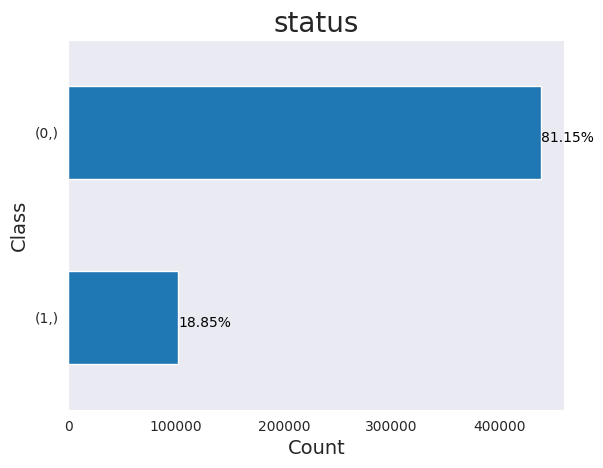

status
0         438384
1         101813
Name: count, dtype: int64


In [22]:
# Plotting the percentage of observations that fall under each class
ax = pd.DataFrame(df.status).value_counts().sort_values().plot(kind="barh")
ax.set_axisbelow(True)
ax.grid()
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20,
     str(round((i.get_width()/total)*100, 2))+'%',
     fontsize=10, color='black')
plt.title("status", fontsize=20)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.show()
print(pd.DataFrame(df.status).value_counts())
fig = ax.get_figure()

The dataset is highly imbalanced with the majority class having 80% and the minority class 20%

Some techiques in handling class imbalance include;
 1. Using SMOTE to create synthetic data to reduce imbalanceness
 2. Undersampling the majority class
 3. Oversampling the minority class
 4. Giving more weight to minority class during modelling

<a name = "Outliers"></a>
## 7. Outliers

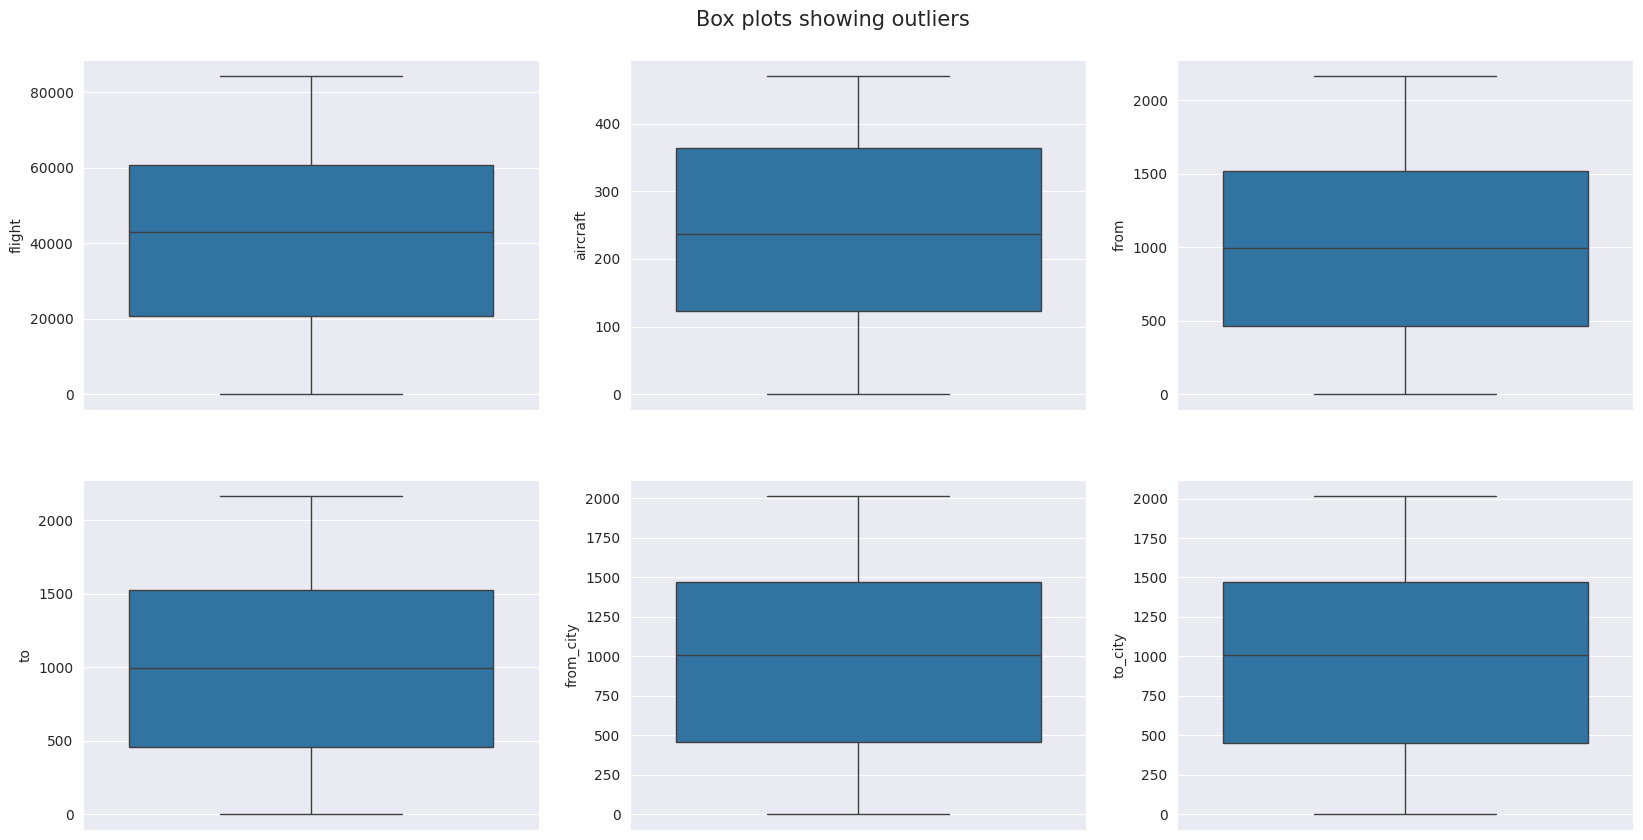

In [18]:
# Plotting boxplots for each of the numerical columns
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 10))
fig.suptitle('Box plots showing outliers', y= 0.93, fontsize = 15)

for ax, data, name in zip(axes.flatten(), df, df.columns):
  sns.boxplot(df[name], ax = ax)

 Some of the techniques we can use to handle outliers:
  1. Log transformations, scaling, box-cox transformations...
  2. Dropping the outliers
  3. Replacing the outliers with mean, median, mode or any other aggregates

In [ ]:
# Show the first few rows of the DataFrame
pd.set_option('display.max_columns', None)
df.head()

,flight,aircraft,from,to,from_city,to_city,year,month,day,hour,dayofweek,quarter,is_year_start,is_year_end,departure_delay,departure_delay_15,status
0,19441,280,92,1633,1554,1426,2024,3,20,12,2,1,0,0,13.0,0,0
1,19319,280,1770,90,1701,1554,2024,3,3,18,6,1,0,0,9.0,0,0
2,19331,280,92,1011,1554,953,2023,12,3,14,6,4,0,0,13.0,0,0
3,19329,280,1010,90,956,1554,2023,12,3,11,6,4,0,0,16.0,1,0
4,19372,280,1358,90,1229,1554,2023,8,11,23,4,3,0,0,0.0,0,0


<a name = "Correlations"></a>
## 8. Correlations

<Figure size 2000x1200 with 0 Axes>

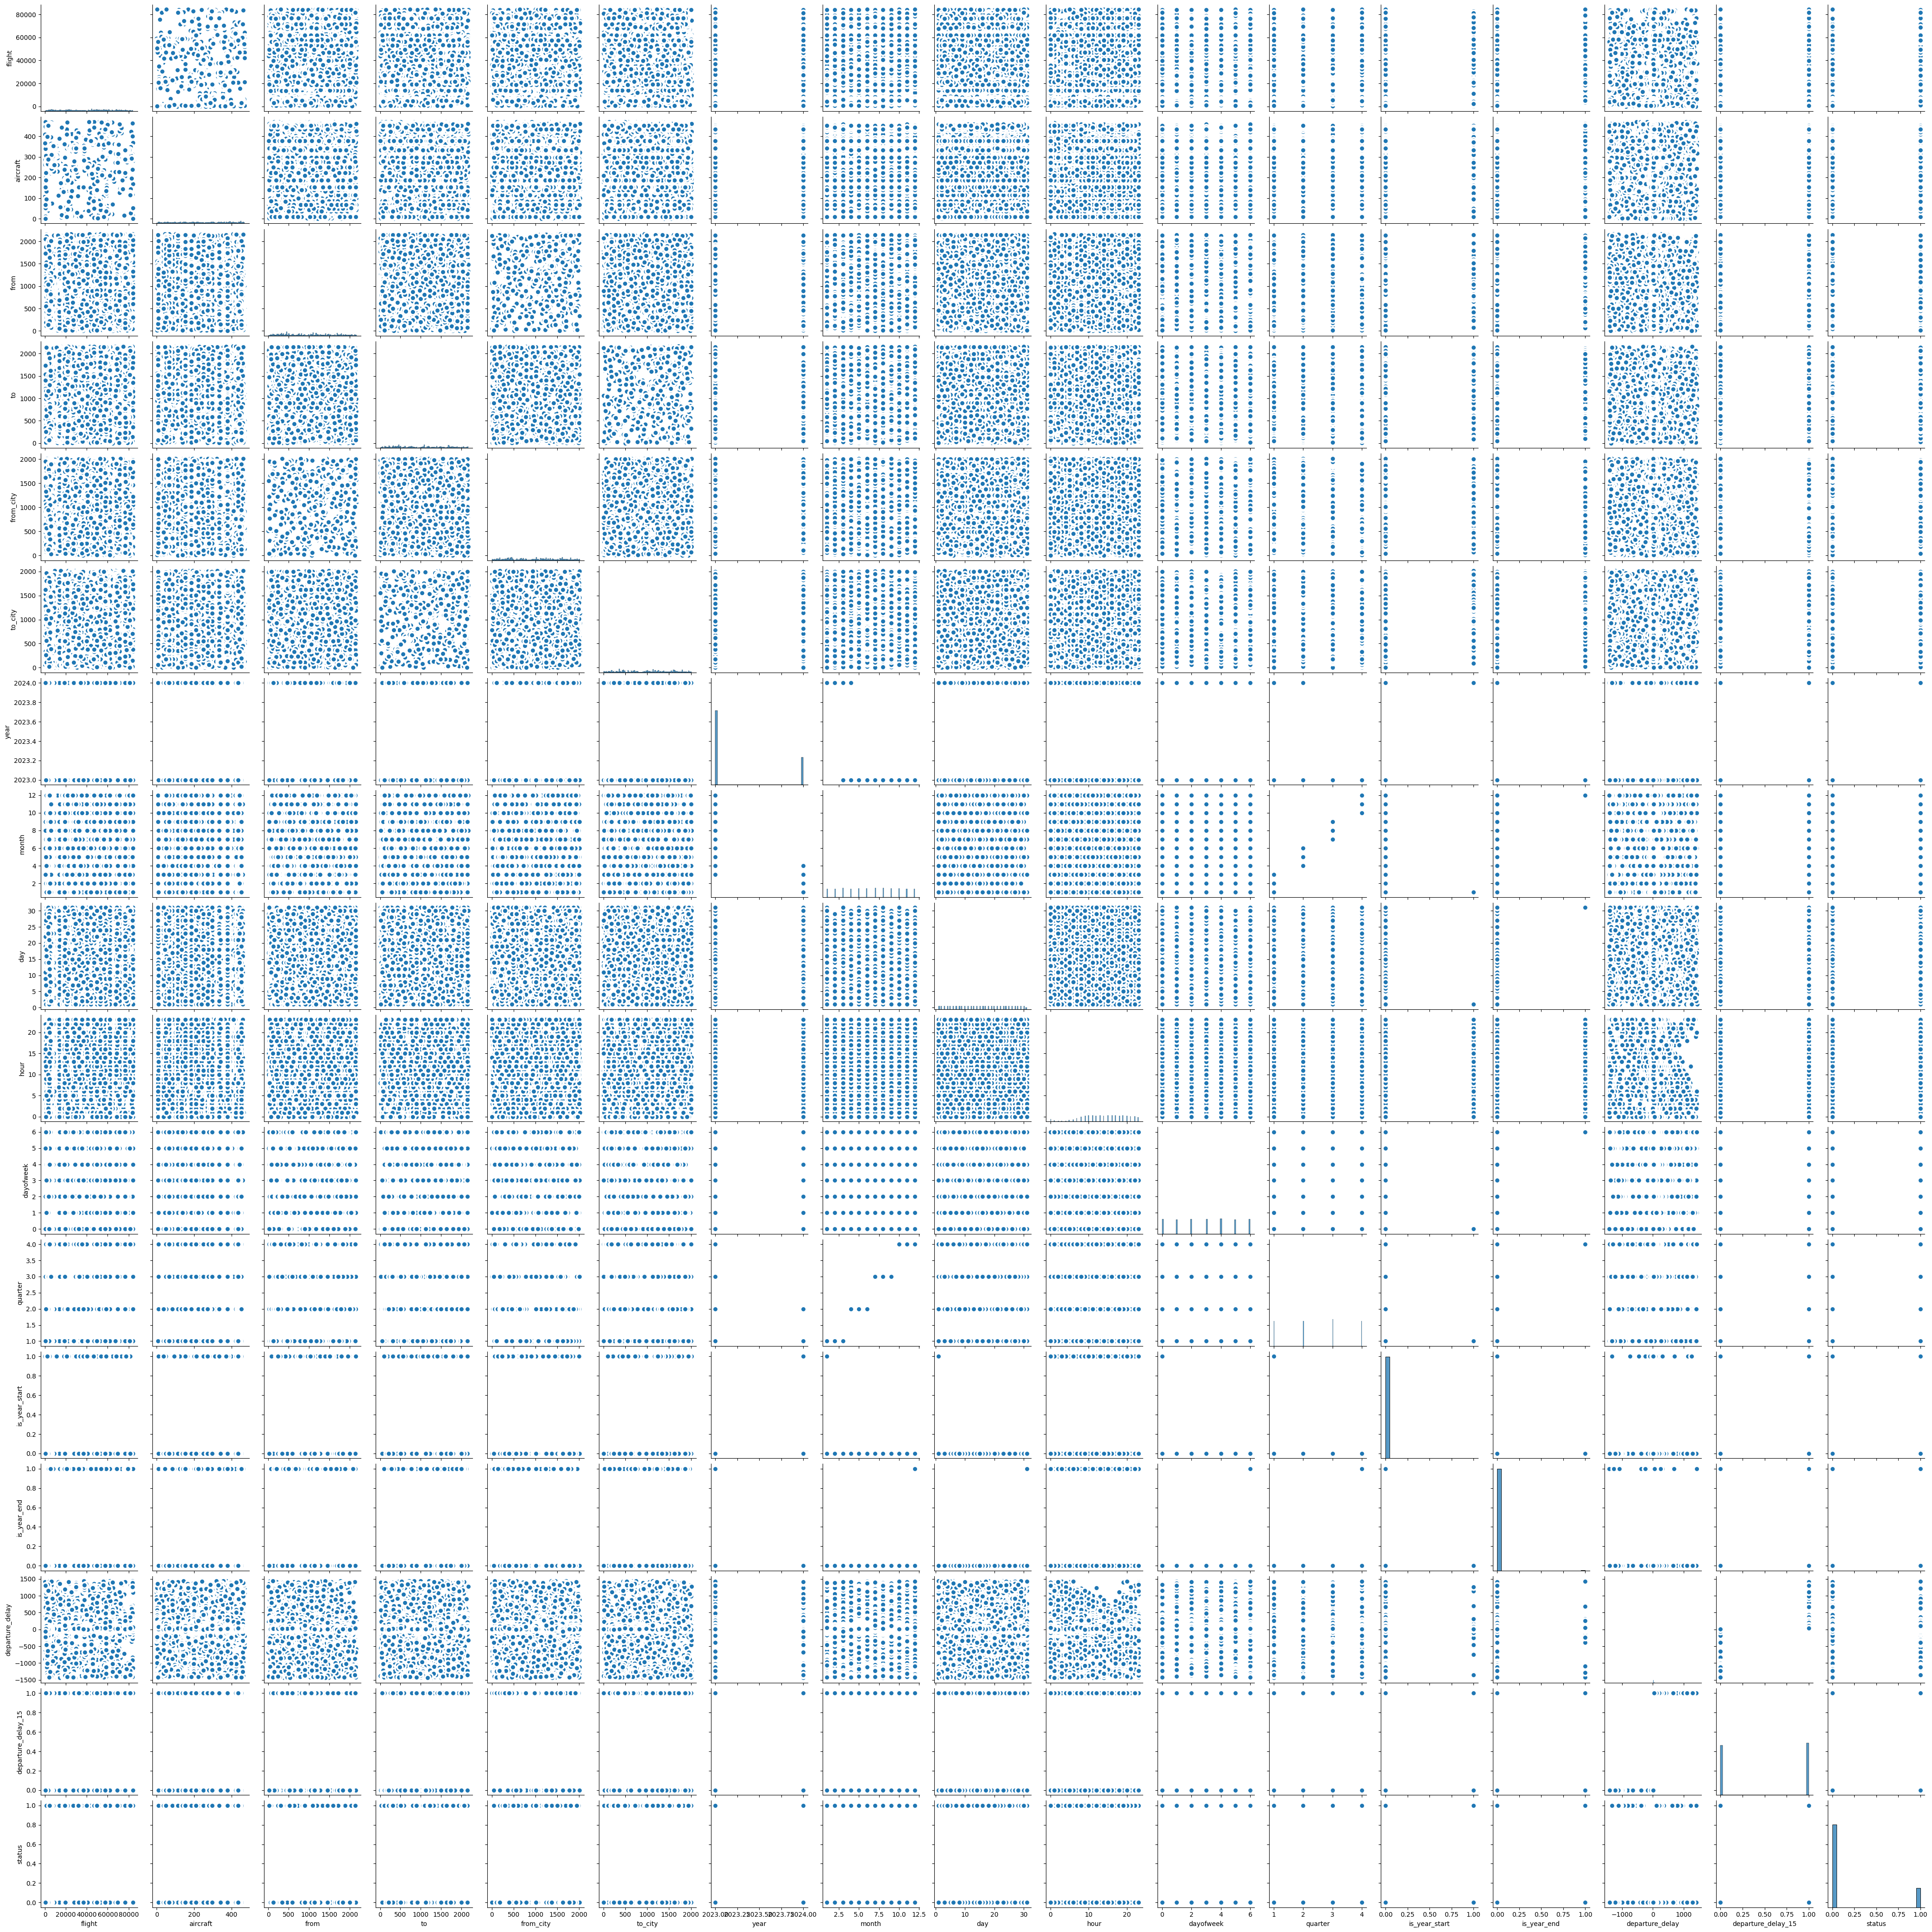

In [13]:
plt.figure(figsize = (20, 12))
sns.pairplot(df, kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

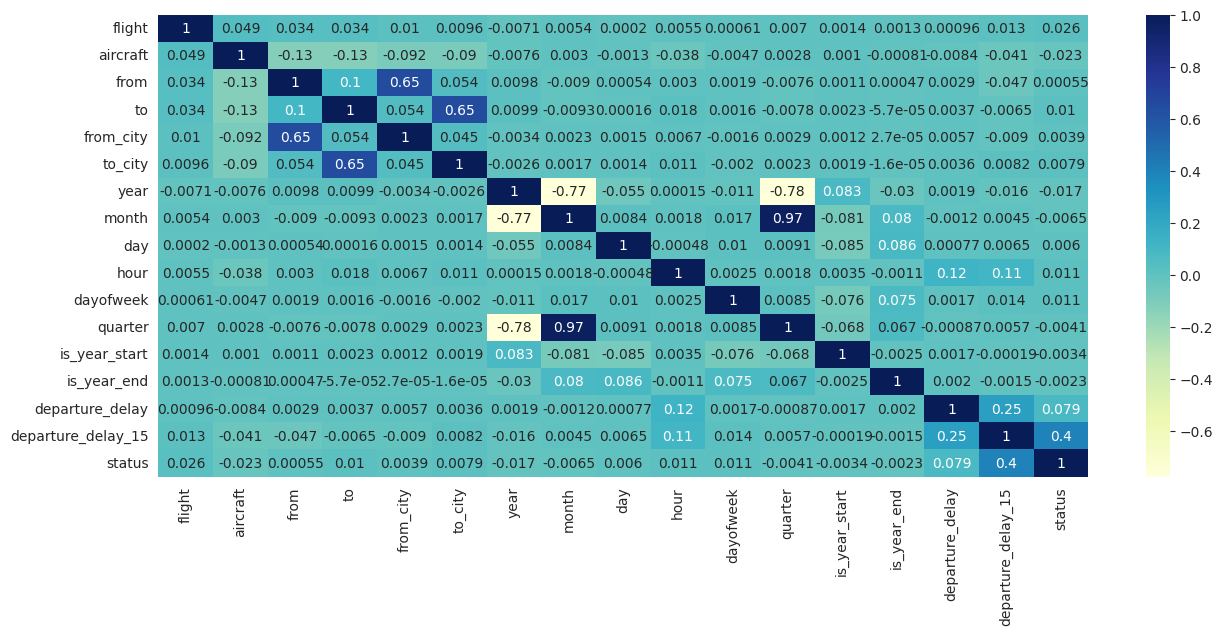

In [19]:
plt.figure(figsize=(15,6))

# plotting correlation heatmap
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

# displaying heatmap
plt.show()

<a name = "Model"></a>
## 9. Model training

In [23]:
X = df.loc[:, df.columns != "status"]
y = np.array(df.loc[:, df.columns == "status"]["status"])

In [24]:
X.head()

,flight,aircraft,from,to,from_city,to_city,year,month,day,hour,dayofweek,quarter,is_year_start,is_year_end,departure_delay,departure_delay_15
0,25459,412,98,1800,1699,1554,2024,3,20,12,2,1,0,0,13.0,0
1,25337,412,1947,96,1859,1699,2024,3,3,18,6,1,0,0,9.0,0
2,25349,412,98,1106,1699,1033,2023,12,3,14,6,4,0,0,13.0,0
3,25347,412,1107,96,1034,1699,2023,12,3,11,6,4,0,0,16.0,1
4,25390,412,1494,96,1334,1699,2023,8,11,23,4,3,0,0,0.0,0


In [25]:
y[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [27]:
print(f"\nDataset shape: {df.shape}")
print(f"X_train shape: {X_train.shape} | X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape} | y_test shape: {y_test.shape}")


Dataset shape: (540197, 17)
X_train shape: (432157, 16) | X_test shape: (108040, 16)
y_train shape: (432157,) | y_test shape: (108040,)


## SMOTE

In [28]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

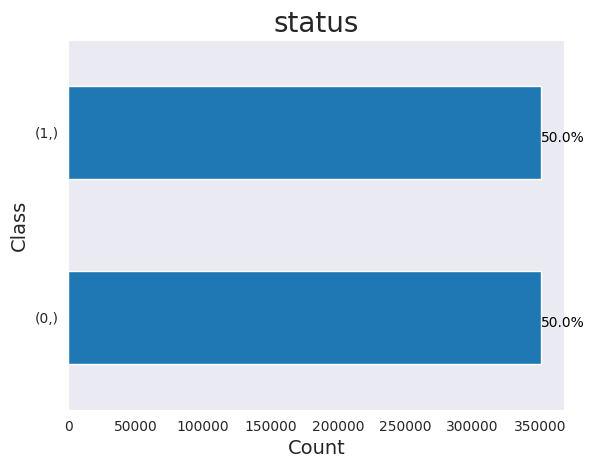

0    350707
1    350707
Name: count, dtype: int64


In [29]:
# Plotting the percentage of observations that fall under each class
ax = pd.DataFrame(y_train).value_counts().sort_values().plot(kind="barh")
ax.set_axisbelow(True)
ax.grid()
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20,
     str(round((i.get_width()/total)*100, 2))+'%',
     fontsize=10, color='black')
plt.title("status", fontsize=20)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.show()
print(pd.DataFrame(y_train).value_counts())
fig = ax.get_figure()

## LGBM Classifier

In [49]:
model = LGBMClassifier()
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 350707, number of negative: 350707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 701414, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier()

In [50]:
model_pred = model.predict(X_test)
# print(confusion_matrix(labels_test, model_pred))
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     87677
           1       0.81      0.82      0.81     20363

    accuracy                           0.93    108040
   macro avg       0.88      0.89      0.88    108040
weighted avg       0.93      0.93      0.93    108040



In [51]:
np.unique(model_pred, return_counts=True)

(array([0, 1]), array([87401, 20639]))

## XGBoost

In [36]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

GradientBoostingClassifier()

In [37]:
model_pred = model.predict(X_test)
# print(confusion_matrix(labels_test, model_pred))
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95     87677
           1       0.74      0.84      0.79     20363

    accuracy                           0.92    108040
   macro avg       0.85      0.89      0.87    108040
weighted avg       0.92      0.92      0.92    108040



In [38]:
np.unique(model_pred, return_counts=True)

(array([0, 1]), array([85060, 22980]))

## Random Forest

In [39]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [40]:
model_pred = model.predict(X_test)
# print(confusion_matrix(labels_test, model_pred))
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     87677
           1       0.82      0.83      0.82     20363

    accuracy                           0.93    108040
   macro avg       0.89      0.89      0.89    108040
weighted avg       0.93      0.93      0.93    108040



In [41]:
np.unique(model_pred, return_counts=True)

(array([0, 1]), array([87443, 20597]))

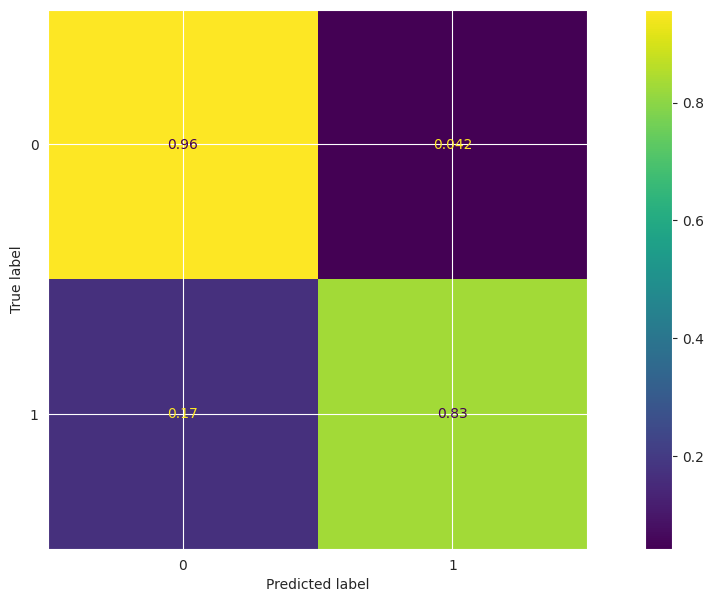

In [47]:
# Confusion matrix
cm = confusion_matrix(y_test, model_pred, labels=model.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(15,7))
disp.plot(ax=ax)
plt.show()

Text(0, 0.5, 'Features')

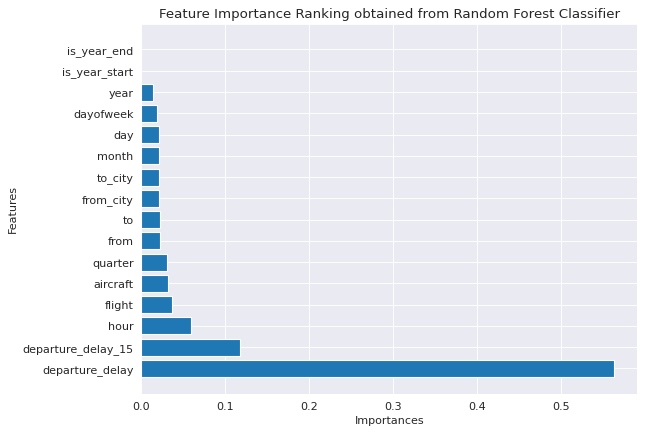

In [48]:
importances = pd.DataFrame({
    "Feature": list(X.columns),
    "Importance": model.feature_importances_
})
importances = importances.sort_values(by="Importance", ascending=False)
importances = importances.set_index("Feature")
importances
plt.figure(figsize=(8, 6), dpi=80)
plt.barh(importances.index, importances.Importance)
plt.title("Feature Importance Ranking obtained from Random Forest Classifier", fontsize=12)
plt.xlabel("Importances")
plt.ylabel("Features")

## To Do

- Use cross-validation techniques, GridSearchCV, RandomSearchCV
- Try different modelling techniques - Stacking classifier, Voting classifiers, ensembling...
- Feature Selection techniques such as RFE, Tree-based feature importance...